In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
#import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


# data loading and preprocessing

In [3]:
#LOADING THE DATA

train_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [4]:
#EDA-EXPLORING THE DATA TO GET SOME INSIGHTS OF ITS STRUCTURE AND DISTRIBUTION

print(train_data.head())                                              #display the first few rows of the train dataset
train_data.info()                                                     # check the data types and missing values
train_data.describe()                                                 # statistics of the train dataset

                                             movieid         reviewerName  \
0                                   marvelous_pirate       Benjamin Henry   
1          tony_montana_frodo_baggins_v_rocky_balboa        Felicia Lopez   
2  darth_vader_katniss_everdeen_sorcerer_donnie_d...  Mr. Charles Burgess   
3                                 lara_croft_glimmer         Ryan Barrett   
4  jason_bourne_surreal_the_terminator_indiana_jones     Alexander Glover   

   isFrequentReviewer                                         reviewText  \
0               False  Henry Selick’s first movie since 2009’s Corali...   
1               False  With a cast that reads like the Vogue Oscar pa...   
2                True  Creed II does not give us anything but another...   
3               False  I know what you're thinking, but this is no Li...   
4               False  Director Fernando Meirelles tells the story wi...   

  sentiment  
0  POSITIVE  
1  NEGATIVE  
2  POSITIVE  
3  POSITIVE  
4  POSITIV

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [5]:
train_data.isnull().sum()                                        # missing values in the dataset

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [6]:
'''
# Define the list of stopwords
stopwords_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just',
    'don', 'should', 'now'
]

"using stopwords decreases my score" 
'''


'\n# Define the list of stopwords\nstopwords_list = [\n    \'i\', \'me\', \'my\', \'myself\', \'we\', \'our\', \'ours\', \'ourselves\', \'you\', \'your\',\n    \'yours\', \'yourself\', \'yourselves\', \'he\', \'him\', \'his\', \'himself\', \'she\',\n    \'her\', \'hers\', \'herself\', \'it\', \'its\', \'itself\', \'they\', \'them\', \'their\',\n    \'theirs\', \'themselves\', \'what\', \'which\', \'who\', \'whom\', \'this\', \'that\',\n    \'these\', \'those\', \'am\', \'is\', \'are\', \'was\', \'were\', \'be\', \'been\', \'being\',\n    \'have\', \'has\', \'had\', \'having\', \'do\', \'does\', \'did\', \'doing\', \'a\', \'an\',\n    \'the\', \'and\', \'but\', \'if\', \'or\', \'because\', \'as\', \'until\', \'while\', \'of\',\n    \'at\', \'by\', \'for\', \'with\', \'about\', \'against\', \'between\', \'into\', \'through\',\n    \'during\', \'before\', \'after\', \'above\', \'below\', \'to\', \'from\', \'up\', \'down\',\n    \'in\', \'out\', \'on\', \'off\', \'over\', \'under\', \'agai

In [7]:
# DATA PREPROCESSING

def clean_text(text):
    text=re.sub('[\W+\s]',' ', text.lower())                      #remove special character
    text=re.sub(r"\d", "", text)                                  #remove digits
    text=re.sub(r'\s+', ' ', text)                                #remove extra space
    #text = ' '.join(word for word in text.split() if word not in stopwords_list) #remove stopwords
    return text

train_data['reviewText'] = train_data['reviewText'].astype(str).apply(clean_text)       #apply the function to train dataset
test_data['reviewText'] = test_data['reviewText'].astype(str).apply(clean_text)         #apply the function to test dataset
label=train_data['sentiment']

In [8]:
print(train_data.head())

                                             movieid         reviewerName  \
0                                   marvelous_pirate       Benjamin Henry   
1          tony_montana_frodo_baggins_v_rocky_balboa        Felicia Lopez   
2  darth_vader_katniss_everdeen_sorcerer_donnie_d...  Mr. Charles Burgess   
3                                 lara_croft_glimmer         Ryan Barrett   
4  jason_bourne_surreal_the_terminator_indiana_jones     Alexander Glover   

   isFrequentReviewer                                         reviewText  \
0               False  henry selick s first movie since s coraline hi...   
1               False  with a cast that reads like the vogue oscar pa...   
2                True  creed ii does not give us anything but another...   
3               False  i know what you re thinking but this is no lim...   
4               False  director fernando meirelles tells the story wi...   

  sentiment  
0  POSITIVE  
1  NEGATIVE  
2  POSITIVE  
3  POSITIVE  
4  POSITIV

In [9]:


# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()


In [10]:
train_features=train_data['reviewText']

In [11]:
encode = LabelEncoder()                                                   # Initialize LabelEncoder

label = encode.fit_transform(train_data['sentiment'])   # Encode the sentiment string labels to numeric labels in the train dataset


In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_features, label, test_size=0.2, random_state=42) #Spliting the preprocessed data into training and validation sets


# Building baseline model Logistic regression with cross validation.Tune the hyperparameters of the model.


In [13]:
# defining pipeline on Tfidf and logreg
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', LogisticRegression(solver='saga'))
])

# Train the pipeline
pipeline.fit(train_features, label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(solver='saga'))])

In [14]:


score_cv = cross_val_score(pipeline, train_features, label, cv=5)       # cross validation                                                          here we pass the logreg model,the training features (x_train),the corresponding label (y_train),and cv=5 to specify 5-fold cross-validation (dividing the data into 5 equal parts).


In [15]:
average_score_cv = score_cv.mean()                                  # calculate the mean cross validation score                                     To get an overall measure of the model's performance we use this function
print("Average Mean Cross-Validation Score:",average_score_cv)

Average Mean Cross-Validation Score: 0.8002924501279234


In [16]:
#hyperparameter tunning using gridsearchcv

param_grid = {'classifier__C': [0.1,0.8, 1,1.2,5,10],'classifier__max_iter': [1000, 5000]}              #it specify the hyperparameter 
grid_search = GridSearchCV(pipeline, param_grid,cv=5)
grid_search.fit(train_features, label)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'classifier__C': [0.1, 0.8, 1, 1.2, 5, 10],
                         'classifier__max_iter': [1000, 5000]})

In [17]:
best_hp = grid_search.best_params_                                    #Get the best hyperparameters
best_score = grid_search.best_score_                                  #it gives the mean cross-validation score of the best hyperparameter

print("Best Mean Cross-Validation Score:", best_score)
print("Best Hyperparameters:", best_hp)

Best Mean Cross-Validation Score: 0.8016810108951363
Best Hyperparameters: {'classifier__C': 5, 'classifier__max_iter': 5000}


In [18]:
# Use the best model from GridSearchCV
final_pipeline = grid_search.best_estimator_
final_pipeline.fit(train_features, label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(C=5, max_iter=5000, solver='saga'))])

In [19]:
# Make predictions on test data
test_pred = final_pipeline.predict(test_data['reviewText'])

In [20]:
#submiting
submission = pd.DataFrame({'sentiment': test_pred})
# Reverse label encoding for submission
submission['sentiment'] = encode.inverse_transform(submission['sentiment'])

# Save the submission file
submission.to_csv('logreg_submission.csv', index_label='id')

#submission.to_csv('logreg_submission.csv', index_label='id')

In [21]:
submission.head(10)

,sentiment
0,POSITIVE
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
5,POSITIVE
6,POSITIVE
7,NEGATIVE
8,POSITIVE
9,POSITIVE


# Visualization of the Data

1. **Visualize the distribution of sentiments (positive and negative) in the training data using a bar plot**

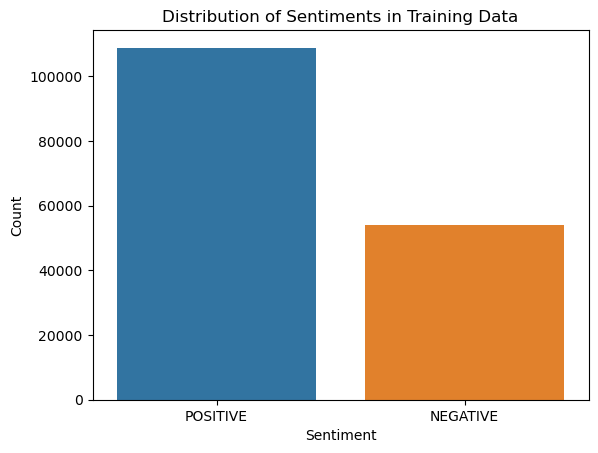

In [22]:
# Visualization: Distribution of Sentiments
sns.countplot(data=train_data, x='sentiment')
plt.title('Distribution of Sentiments in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

2. **Visualize the distribution of review lengths (number of words) for both positive and negative reviews**

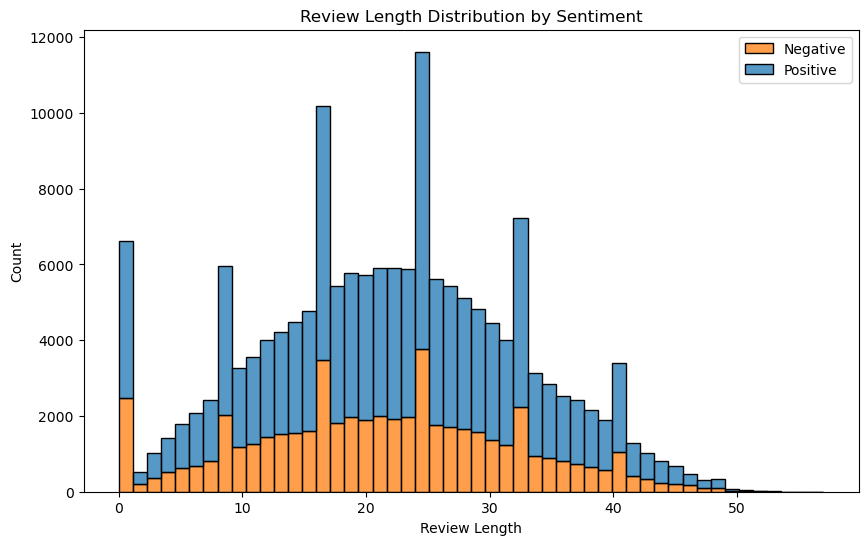

In [23]:
train_data['reviewLength'] = train_features.apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='reviewLength', hue='sentiment', multiple='stack', bins=50)
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.show()


3. **word clouds to visualize the most frequent words in both positive and negative reviews**

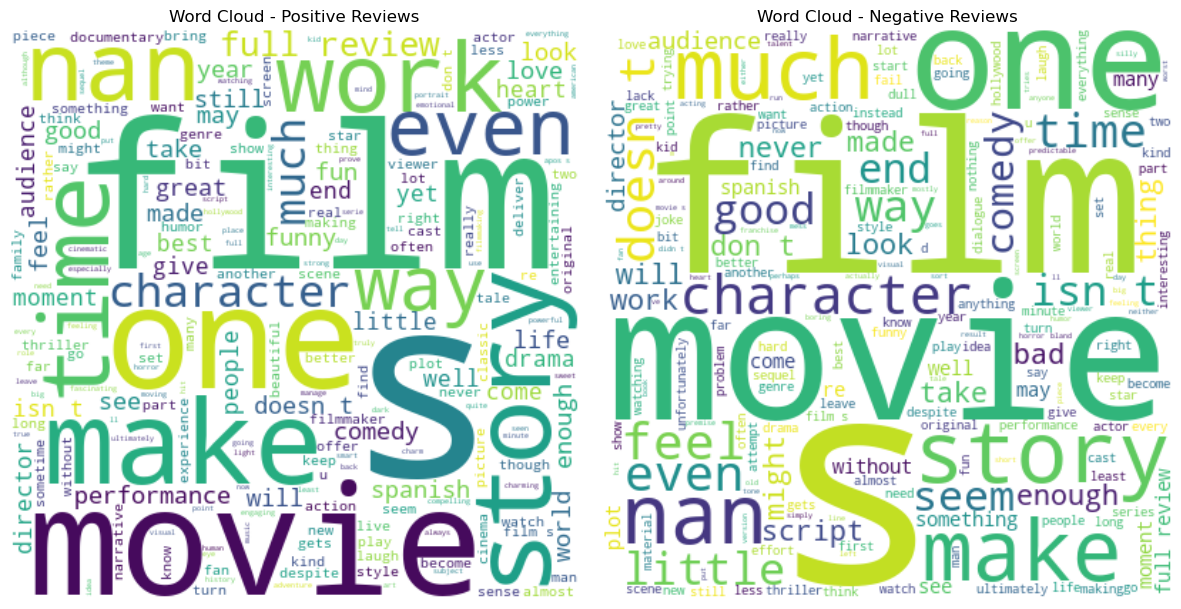

In [24]:
'''

positive_reviews = train_data[label == 1]['reviewText']
negative_reviews = train_data[label == 0]['reviewText']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=400, height=400, background_color='white').generate(' '.join(positive_reviews))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=400, height=400, background_color='white').generate(' '.join(negative_reviews))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()
'''

4. **Visualize the top N most frequent words for both positive and negative reviews**

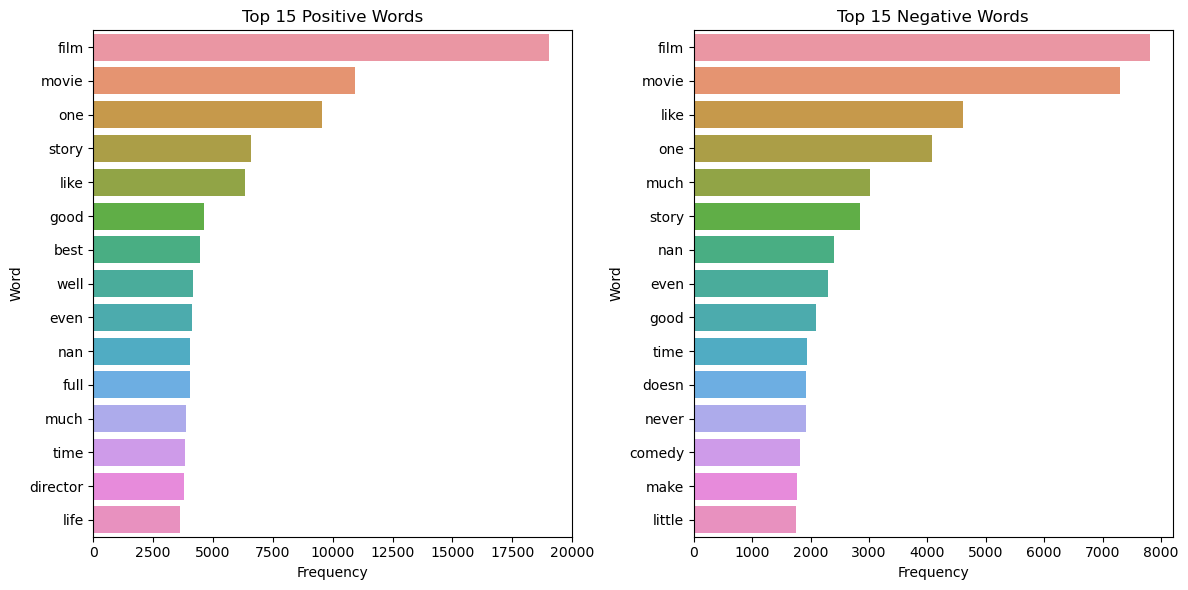

In [25]:
'''
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of stopwords
stopwords_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just',
    'don', 'should', 'now'
]

# Tokenize the text and count word frequencies
positive_words = ' '.join(positive_reviews).split()
negative_words = ' '.join(negative_reviews).split()

# Remove stopwords from positive and negative word lists
positive_words = [word for word in positive_words if word.lower() not in stopwords_list]
negative_words = [word for word in negative_words if word.lower() not in stopwords_list]

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Top N words
top_n = 15

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=[count for word, count in positive_word_counts.most_common(top_n)],
            y=[word for word, count in positive_word_counts.most_common(top_n)])
plt.title('Top {} Positive Words'.format(top_n))
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplot(1, 2, 2)
sns.barplot(x=[count for word, count in negative_word_counts.most_common(top_n)],
            y=[word for word, count in negative_word_counts.most_common(top_n)])
plt.title('Top {} Negative Words'.format(top_n))
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()
'''

# Important insights or findings from the dataset

1.**Sentiment Distribution:**

The sentiment distribution in the training data indicates that there are approximately half as many negative reviews compared to positive reviews. .


2.**Word Cloud Analysis:**

The word clouds for positive and negative reviews reveal some distinctive terms associated with each sentiment.
Common positive terms may include words like "film," "good," and "love" while negative terms could involve words like "film", "enough," and "film."

3.**Review Length and Sentiment:**

The review length distribution by sentiment indicates that both positive and negative reviews have a wide range of lengths.
The count of positive review is more than negative review for a particular review length.

4.**Top Words Comparison:**

Positive reviews commonly use terms like "story", "good" and "like" while negative reviews often contain words such as "film", "never" and "movie"

5.**Model Performance:**

The model's average cross-validation score reflects its ability to generalize well across different folds of the data.
The hyperparameter tuning process using GridSearchCV helps find the best combination of parameters for the logistic regression model.
Average Mean Cross-Validation Score: 0.8002985943324024
Best Mean Cross-Validation Score: 0.8002985943324024
Best Hyperparameters: {'classifier__C': 1, 'classifier__max_iter': 1000}


6.**Feature Engineering Impact:**

The text data has been successfully transformed into a numerical format using TF-IDF vectorization.
This transformation allows the model to capture patterns and relationships between words, contributing to its predictive performance.


# Potential for Improvement



While the provided insights offer valuable information, further analysis could explore additional features or techniques to enhance model performance.
Experimentation with more advanced preprocessing steps using NLTK,TextBlob and other NLP techniques.
we can use Deep learning model like RNN,KNN and TensorFlow,PyTorch.